In [414]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# State name and abbrev
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 
          'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 
          'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 
          'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 
          'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 
          'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 
          'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 
          'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 
          'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 
          'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 
          'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}
states_abb = dict((v,k) for k,v in states.items())

# Load and Clean Data 

In [132]:
# Load Hospital Compare Data downloaded from CMS
id_2015 = next(os.walk('2015/'))[2]

df_year = pd.DataFrame()

for file in id_2015:
    f= pd.read_csv('2015/' + file, encoding = 'cp1252')
    f['year'] = f['Measure End Date'].astype(str).apply(lambda x: x[-4:])
    f = f[f['HCAHPS Question'] == 'Summary star rating']
    f = f[f['Patient Survey Star Rating'] !='Not Available']
    f['Patient Survey Star Rating'] = f['Patient Survey Star Rating'].astype(np.float32)
    #f = f.drop(columns=['Measure Start Date', 'Measure End Date', 'Address','County Name', 'Phone Number', 'HCAHPS Measure ID','Survey Response Rate Percent Footnote','Patient Survey Star Rating Footnote','HCAHPS Linear Mean Value','HCAHPS Answer Percent Footnote'], axis=1)
    df_year = pd.concat([df_year, f])

df = df_year.copy()
df = df.drop(columns=['Provider ID','Address','HCAHPS Measure ID','HCAHPS Answer Percent Footnote', 'Survey Response Rate Percent Footnote',
                    'Number of Completed Surveys Footnote','HCAHPS Linear Mean Value','Patient Survey Star Rating Footnote','Phone Number',
                      'Measure Start Date', 'Measure End Date','HCAHPS Question', 'Footnote'], axis=1)
df.year = df.year.astype(np.str)
df1 = df.groupby(['year', 'State'], as_index=False).mean() #.sort_values(['Patient Survey Star Rating'],ascending=False)
y_2014 = df1[df1.year == '2014'].sort_values('Patient Survey Star Rating', ascending=False)
y_2015 = df1[df1.year == '2015'].sort_values('Patient Survey Star Rating', ascending=False)
y_2016 = df1[df1.year == '2016'].sort_values('Patient Survey Star Rating', ascending=False)
y_2017 = df1[df1.year == '2017'].sort_values('Patient Survey Star Rating', ascending=False)

dfall=pd.merge(pd.merge(pd.merge(y_2014, y_2015, how='outer', on=['State']), y_2016, how='outer', on=['State']), y_2017, how='outer', on=['State'])

dfall.columns=['year_x', 'State', 'Patient Survey Star Rating_x', 'ZIP Code_x',
       'year_y', 'Patient Survey Star Rating_y', 'ZIP Code_y', 'year_a',
       'Patient Survey Star Rating_a', 'ZIP Code_a', 'year_b',
       'Patient Survey Star Rating_b', 'ZIP Code_b']
dfall.drop(columns=['ZIP Code_x','ZIP Code_y','ZIP Code_a','ZIP Code_b', 'year_x','year_b', 'year_y','year_a' ], axis=1, inplace=True)
dfall.rename(columns={'Patient Survey Star Rating_x': 'Rating_2014','Patient Survey Star Rating_y': 'Rating_2015', 
         'Patient Survey Star Rating_a': 'Rating_2016', 'Patient Survey Star Rating_b': 'Rating_2017' }, inplace=True)    
dfall['Rating'] = dfall[['Rating_2014','Rating_2015','Rating_2016','Rating_2017']].mean(axis=1)
dfall = dfall[['State', 'Rating']].sort_values(by=['Rating'], ascending=False)

C:\Users\wyan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\wyan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  del sys.path[0]


In [6]:
# Feature1 -- Population:
population = pd.read_excel('feature/nst-est2017-01.xlsx', skiprows=3).iloc[5:, :].reset_index()
population.rename(columns={'Unnamed: 0': 'State',2016:'Population'}, inplace=True)
population.State=population.State.astype(np.str).apply(lambda x: x.replace('.', ''))
population['State'] = population['State'].map(states_abb)
population.drop(columns=['Estimates Base','Census', 2010, 2011, 2012, 2013,2014,2015,2017,'index'],inplace=True)

In [118]:
# Feature2 -- Hospital No.
hospital = pd.read_csv('2015/' + 'HCAHPS - Hospital12.csv', encoding = 'cp1252')
hospital = hospital[['Hospital Name', 'State']].groupby(['State','Hospital Name'], as_index=False).size().reset_index()
dfc = pd.DataFrame(hospital['State'].value_counts()).reset_index()
dfc.rename(columns={'index':'State', 'State':'Hospital'}, inplace=True)

In [16]:
# Feature3~6 -- Expenditures by Service by State to Physician, Hospital, Prescription and Nurses
statecost = pd.read_csv('feature/Expenditures by Service by State.csv', skiprows=1)
statecost=statecost.iloc[1:52]
#dfpdm.drop(columns = ['Nonmetropolitan', 'Total'], inplace=True)
statecost['Location']=statecost['Location'].map(states_abb)
statecost.rename(columns={'Location':'State'}, inplace=True)
statecost.drop(['Total','Home Health Care','Other Health, Residential, and Personal Care','Medical Durables','Dental Services'], axis=1, inplace=True)
statecost[['Hospital Care','Physician and Other Professional Services','Prescription Drugs and Other Medical Nondurables',
           'Nursing Home Care']]=statecost[['Hospital Care','Physician and Other Professional Services',
            'Prescription Drugs and Other Medical Nondurables','Nursing Home Care']]*100
statecost.rename(columns={'Hospital Care':'StateHospi','Physician and Other Professional Services':'StatePhy',
                'Prescription Drugs and Other Medical Nondurables':'StatePrescri','Nursing Home Care':'StateNur' }, inplace=True)

In [19]:
# Feature7 -- Hospital Cost Inpatient Per Day
hospiCost = pd.read_csv('feature/HospitalCostInpatientDay.csv', skiprows=1)
hospiCost=hospiCost.iloc[1:52]
#dfpdm.drop(columns = ['Nonmetropolitan', 'Total'], inplace=True)
hospiCost['Location']=hospiCost['Location'].map(states_abb)
hospiCost.rename(columns={'Location':'State'}, inplace=True)
hospiCost['Expenses per Inpatient Day'] = hospiCost['Expenses per Inpatient Day'].astype(str).apply(lambda x: x.replace('$', ''))
hospiCost['Expenses per Inpatient Day'] = hospiCost['Expenses per Inpatient Day'].apply(lambda x: x.replace(',', ''))
hospiCost['Expenses per Inpatient Day'] = hospiCost['Expenses per Inpatient Day'].astype(np.float)

In [21]:
# Feature8 -- Physician number per State
PhysciNo= pd.read_csv('feature/Physician.csv', skiprows=1)
PhysciNo=PhysciNo.iloc[1:52]
PhysciNo['Location']=PhysciNo['Location'].map(states_abb)
PhysciNo.rename(columns={'Location':'State', 'Total': 'PhysicianNo'}, inplace=True)

In [22]:
# Feature9 -- Percent of Adults Without a Usual Place of Medical Care
AdultNoPhysician= pd.read_csv('feature/Percent of Adults Without a Usual Place of Medical Care.csv', skiprows=2)
AdultNoPhysician=AdultNoPhysician.iloc[1:52]
#dfpdm.drop(columns = ['Nonmetropolitan', 'Total'], inplace=True)
AdultNoPhysician['Location']=AdultNoPhysician['Location'].map(states_abb)
AdultNoPhysician.rename(columns={'Location':'State', 'Percentage':'AdultNoPhysican%'}, inplace=True)
AdultNoPhysician['AdultNoPhysican%'] = AdultNoPhysician['AdultNoPhysican%']*100

In [23]:
# Feature10 -- Nursing Facilities per State
NurseFacility = pd.read_csv('feature/Nursing Facilities.csv', skiprows=1)
NurseFacility =NurseFacility .iloc[1:52]
#dfpdm.drop(columns = ['Nonmetropolitan', 'Total'], inplace=True)
NurseFacility ['Location']=NurseFacility ['Location'].map(states_abb)
NurseFacility .rename(columns={'Location':'State'}, inplace=True)

In [25]:
# Feature11 -- Physician shortage per area 1:3million population
PhysicianShort = pd.read_csv('feature/HPSAs.csv', skiprows=1)
PhysicianShort=PhysicianShort.iloc[1:52]
PhysicianShort['Location']=PhysicianShort['Location'].map(states_abb)
PhysicianShort.rename(columns={'Location':'State'}, inplace=True)
PhysicianShort.drop('Footnotes', axis=1, inplace=True)

In [27]:
# Feature12 ~ 15 -- Insurance Coverage Rate by State: 'Employer','Medicaid','Uninsured','Medicare'
insured = pd.read_csv('feature/Insurance_coverage.csv', skiprows=1)
insured = insured.iloc[1:52]
insured.rename(columns={'Location': 'State'}, inplace=True)
#insured.sort_values(by=['Uninsured'], inplace=True)
insured['State'] = insured['State'].map(states_abb)
insured.drop(['Other Public','Total','Non-Group'], axis = 1, inplace=True)
insured[['Employer','Medicaid','Uninsured','Medicare']] = insured[['Employer','Medicaid','Uninsured','Medicare']] * 100

In [29]:
# Feature16 -- Poverty Level
poverty = pd.read_csv('feature/Poverty.csv', skiprows=1)
poverty=poverty.iloc[1:53]
poverty['Location']=poverty['Location'].map(states_abb)
poverty.rename(columns={'Location':'State'}, inplace=True)
poverty=poverty.iloc[:, :3]

,State,Under 100%,100-199%
1,AL,795800.0,901600.0
2,AK,92500.0,101000.0
3,AZ,1119500.0,1296200.0
4,AR,475500.0,563400.0
5,CA,5480200.0,6999700.0


In [31]:
# Feature17 -- Metropolitan Level
metropolitan = pd.read_csv('feature/Metro_level.csv', skiprows=2)
metropolitan=metropolitan.iloc[1:52]
metropolitan.drop(columns = ['Nonmetropolitan', 'Total'], inplace=True)
metropolitan['Location']=metropolitan['Location'].map(states_abb)
metropolitan.rename(columns={'Location':'State'}, inplace=True)
metropolitan['Metropolitan'] = metropolitan['Metropolitan'] * 100

In [32]:
# Feature18 -- Obese rate
obese= pd.read_csv('feature/Obese.csv', skiprows=1)
obese=obese.iloc[1:52]
obese['Location']=obese['Location'].map(states_abb)
obese.rename(columns={'Location':'State'}, inplace=True)
obese['Adult Overweight/Obesity Rate'] = obese['Adult Overweight/Obesity Rate']*100
obese.drop(['Footnotes'], axis=1, inplace=True)

In [34]:
# Feature19 -- Median Income
mincome = pd.read_csv('feature/Median_income.csv', skiprows=1)
mincome=mincome.iloc[1:52]
mincome['Location']=mincome['Location'].map(states_abb)
mincome.rename(columns={'Location':'State'}, inplace=True)
mincome.rename(columns={'Unnamed: 1':'Median_income'}, inplace=True)
mincome['Median_income'] = mincome['Median_income'].apply(lambda x: x.replace('$', ''))
mincome['Median_income'] = mincome['Median_income'].apply(lambda x: x.replace(',', ''))
mincome['Median_income'] = mincome['Median_income'].astype(np.float)

In [98]:
# Feature20~28 -- Hospital Ownership
own = pd.read_csv('feature/Hospital General Information.csv',encoding = 'cp1252')
own.drop(['Phone Number','Address','County Name','Readmission national comparison footnote','Patient experience national comparison footnote',
          'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote','Hospital overall rating footnote',
         'Mortality national comparison footnote','Safety of care national comparison footnote','Timeliness of care national comparison footnote',
         'Efficient use of medical imaging national comparison footnote','Meets criteria for meaningful use of EHRs','Emergency Services'], axis=1, inplace=True)
a = pd.DataFrame(own.groupby(['State','Hospital Ownership'], as_index=False).size()).reset_index()
a.columns.values[2] = 'Count'
lst = a['Hospital Ownership'].unique()

f2 = a[a['Hospital Ownership'] == lst[0]]
for i in range(1, len(lst)):
    f = a[a['Hospital Ownership'] == lst[i]]
    f.rename(columns={'Count': lst[i]}, inplace=True)
    f.drop(['Hospital Ownership'], axis=1, inplace=True)
    f2 = pd.merge(f2, f, on='State', how='outer')
f2.drop(['Hospital Ownership', 'Tribal'], axis=1, inplace=True)
f2.rename(columns={'Count': 'Government-Federal'}, inplace=True)
f2.fillna(0, inplace=True)

C:\Users\wyan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\wyan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [150]:
# Feature29 -- Readmission Rate by State
read = pd.read_csv('feature/Hospital_Readmission_Rates.csv')
read1 = read[['Hospital Name','State','Expected Readmission Rate']]
read1 = read1[read1['Expected Readmission Rate'] != 'Not Available']
read1['Expected Readmission Rate']=read1['Expected Readmission Rate'].astype(np.float)
read_hos = read1.groupby(['Hospital Name', 'State'], as_index=False).mean()
read_state = read_hos.groupby(['State'], as_index=False).mean().sort_values(by=['Expected Readmission Rate'], ascending=False)

In [151]:
# Feature35 -- Population by Age
age = pd.read_csv('feature/Population Distribution by Age.csv', skiprows=1)
age = age.iloc[1:52]
age['Location']=age['Location'].map(states_abb)
age.rename(columns={'Location':'State'}, inplace=True)
age.drop('Total', axis=1, inplace=True)
age.iloc[:, 1:] = age.iloc[:, 1:]*100

In [427]:
flst = [population,statecost,dfc,hospiCost,PhysciNo, AdultNoPhysician,NurseFacility,PhysicianShort,insured,poverty,metropolitan,obese,mincome,f2,age,read_state]
df_35 = dfall.copy()
for item in flst:
    df_35 = pd.merge(df_35, item, on=['State'], how='inner') 
df_35.columns.values


array(['State', 'Rating', 'Population', 'StateHospi', 'StatePhy',
       'StatePrescri', 'StateNur', 'Hospital',
       'Expenses per Inpatient Day', 'PhysicianNo', 'AdultNoPhysican%',
       'Number of Nursing Facilities',
       'Practitioners Needed to Remove HPSA Designation', 'Employer',
       'Medicaid', 'Medicare', 'Uninsured', 'Under 100%', '100-199%',
       'Metropolitan', 'Adult Overweight/Obesity Rate', 'Median_income',
       'Government-Federal', 'Government - Local', 'Proprietary',
       'Voluntary non-profit - Church', 'Voluntary non-profit - Other',
       'Voluntary non-profit - Private',
       'Government - Hospital District or Authority',
       'Government - State', 'Physician', 'Children 0-18', 'Adults 19-25',
       'Adults 26-34', 'Adults 35-54', 'Adults 55-64', '65+',
       'Expected Readmission Rate'], dtype=object)

# Data Visulization

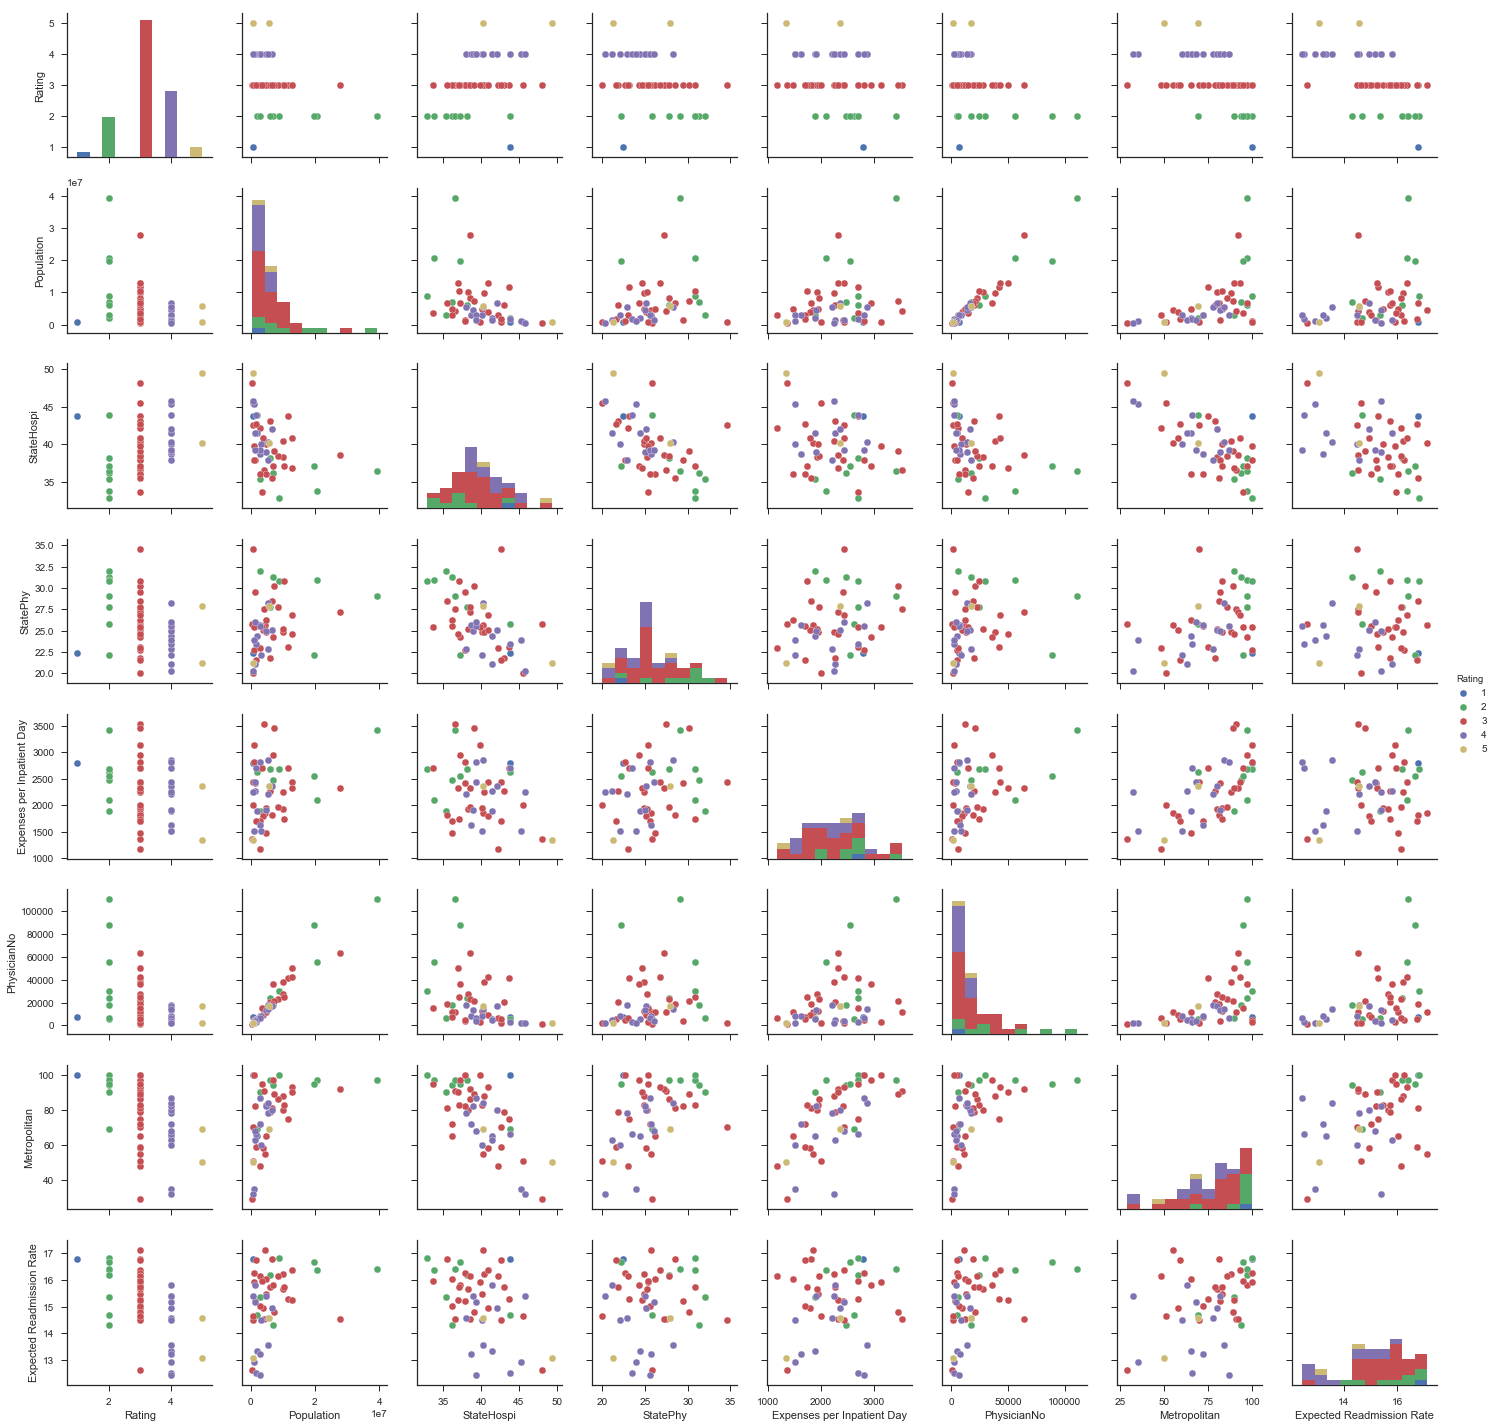

In [433]:
# scatter matrix
import seaborn as sns
sns.set(style="ticks")

dff = df_35.copy()
dff['Rating'] = y_data
sns.pairplot(dff.iloc[:, [1,2,3,4,8,9,19,-1]], hue='Rating')

In [438]:
#plt.figure(figsize=(16,16))
#plt.matshow(dff.corr())
#pd.scatter_matrix(dff)
f, ax = pl.subplots(figsize=(10, 8))
corr = dataframe.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [194]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
pca = PCA()
X_data = df_35.iloc[:, 2:]
label = df_35.iloc[:,1 ]
X = scaler.fit_transform(df_35.iloc[:, 1:])
Xpca = pca.fit_transform(X)

In [195]:
label = np.where(label>3.50, 4.0,label)
label = np.where((label<=3.50) & (label>2.7), 3.0, label)
label = np.where(label<2.7, 2.0, label)

In [196]:
pca.explained_variance_ratio_

array([2.65070627e-01, 1.43679929e-01, 1.19893791e-01, 9.00583708e-02,
       5.94085785e-02, 4.83661129e-02, 4.05708160e-02, 3.08552999e-02,
       2.92006532e-02, 2.43080159e-02, 2.20519491e-02, 1.94597440e-02,
       1.66661515e-02, 1.41900485e-02, 1.29787199e-02, 1.03191208e-02,
       9.13231968e-03, 8.06929059e-03, 6.08697242e-03, 5.09677229e-03,
       4.28081253e-03, 3.57062642e-03, 3.32423960e-03, 2.56341786e-03,
       2.10813513e-03, 2.00348183e-03, 1.70001675e-03, 1.43690220e-03,
       1.25605622e-03, 8.86974571e-04, 7.04831955e-04, 3.50882283e-04,
       2.03695248e-04, 9.44616832e-05, 3.70723319e-05, 1.45426570e-05,
       5.67744874e-07])

Text(0,1,'95% Variance Explained')

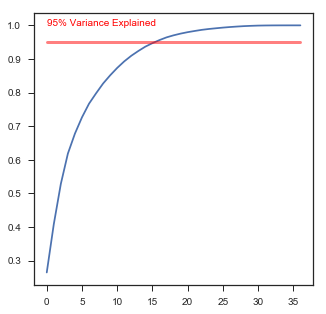

In [408]:
plt.figure(figsize=[5,5])
plt.plot(np.cumsum(pca.explained_variance_ratio_), label= 'Training')
plt.plot([0,36], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')

No handles with labels found to put in legend.


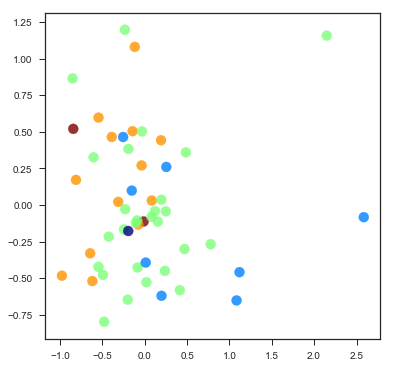

In [421]:
plt.figure(figsize=(6,6))
plt.scatter(Xpca[:,0], Xpca[:,1], c=y_data, s=100, alpha=0.8, cmap=plt.get_cmap('jet'))
plt.legend()

Top 15 important features are: 
Expected Readmission Rate
Metropolitan
StateHospi
Practitioners Needed to Remove HPSA Designation
PhysicianNo
Population
Children 0-18
StatePrescri
AdultNoPhysican%
Adult Overweight/Obesity Rate
Government-Federal
Hospital
StateNur
Uninsured
Government - Local


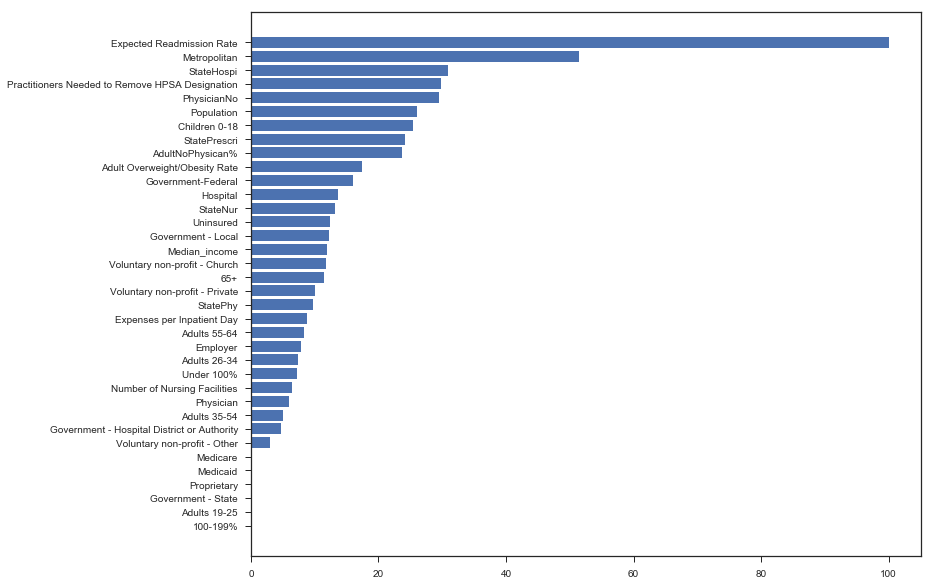

In [429]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_data, label)
importances = forest.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_data.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 15 important features are: ')
for feature in feature_names_sort[::-1][:15]:
    print (feature)
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
#plt.title('Relative Feature Importance', fontsize=20)
plt.show()

In [403]:
from sklearn.svm import SVC
cls=SVC(kernel='rbf',C=100.0,gamma=0.1)
cls.fit(X, label)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [404]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y_data,shuffle=True, 
                                                    test_size=0.2,random_state = False)

In [405]:
clf = cls.fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

In [407]:
clf.score(X_test, y_test)

0.8181818181818182

In [396]:
y_data = df_35.iloc[:,1].copy()

In [397]:
y_data = np.where(y_data>=4.0, 5,y_data)
y_data = np.where((y_data>=3.50) & (y_data<4.0), 4, y_data)
y_data = np.where((y_data>=3.0) & (y_data<3.5), 3, y_data)
y_data = np.where((y_data>=2.5) & (y_data<3.0), 2, y_data)
#y_data = np.where(y_data<2.5, 1, y_data)


In [422]:
y_data = y_data.astype(np.int)
y_data

array([5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 1])